# The objectives comprised of two folds:
# <a href='#resting-state'>1. Resting State</a>

# <a href='#ISC'>2. Inter-subject Correlation study (ISC)</a>

In [12]:
import mne
import pathlib
from mne.externals.pymatreader import read_mat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import axes3d
import numpy as np

In [2]:
from warnings import simplefilter 
simplefilter(action='ignore', category=DeprecationWarning)

In [24]:
import os
subjs = ['NDARCD401HGZ','NDARDX770PJK', 'NDAREZ098ZPE', 'NDARGY054ENV', 'NDARMR242UKQ', 'NDARRD720XZK', 'NDARTR840XP1', 'NDARXJ696AMX', 'NDARYY218AGA', 'NDARZP564MHU']


In [22]:
def csv_to_raw_mne(path_to_file,path_to_montage_ses,fs,path_to_events,filename,state,montage = 'GSN-HydroCel-129'):
    ''' Load csv files of data, chan locations and events and return a raw mne instance'''
    data = np.loadtxt(path_to_file,delimiter =',')
    chans = pd.read_csv(path_to_montage_ses,sep = ',',header = None)
    ch_list=['E1', 'E8', 'E14', 'E17', 'E21', 'E25', 'E32', 'E38', 'E43', 'E44', 'E48', 'E49', 'E56', 'E57', 'E63', 'E64', 'E69', 'E73', 'E74', 'E81', 'E82', 'E88', 'E89', 'E94', 'E95', 'E99', 'E100', 'E107', 'E113', 'E114', 'E119', 'E120', 'E121', 'E125', 'E126', 'E127', 'E128']
    print(len(ch_list))
    ch_names = list(chans.values[1:,0])

    
    if state == 'Rest':
        ch_names_appended = list(np.append(ch_names,'stim_channel'))
        types = ['eeg']*(len(ch_names_appended)-1)
        types.append('stim')
        data2 = np.zeros([1,len(data[0])]) #len(raw.times)
        data_appended = np.append(data,data2,axis = 0)
        info = mne.create_info(ch_names_appended,sfreq = fs,ch_types = types)
        raw = mne.io.RawArray(data_appended, info)
    
    else:   
        types = ['eeg']*(len(ch_names))
        info = mne.create_info(ch_names,sfreq = fs,ch_types = types)
        raw = mne.io.RawArray(data, info)
    
    # set standard montage
    if montage:
        raw.set_montage(montage)

    if path_to_events:
        # parse events file
        raw_events = pd.read_csv(path_to_events, sep = r'\s*,\s*', header = None, engine = 'python')
        values = raw_events[0].to_list()
        
        
        print(filename)
        if filename == 'NDARDX770PJK':
            values.extend(["break cnt"])
            
        idx = [i for i, e in enumerate(values) if e == 'break cnt']
        if state == 'Rest': 
            #idx = [i for i, e in enumerate(values) if e == 'break cnt']
            samples = raw_events[1][idx[0] + 1:idx[1]].to_numpy(dtype = int)
            event_values = raw_events[0][idx[0] + 1:idx[1]].to_numpy(dtype = int)
            
        else:
            samples = raw_events[1][1:idx[0]].to_numpy(dtype = int)
            event_values = raw_events[0][1:idx[0]].to_numpy(dtype = int)
     

        events = np.zeros((len(samples), 3))
        
        events = events.astype('int')
        events[:, 0] = samples
        events[:, 2] = event_values
        
        # Appending one row of 'ones'. Will be easier to stop parsing once we hit 1
        events_final = np.append(events,np.ones((1, 3)),axis = 0).astype('int')
        raw = exclude_channels_from_raw(raw, ch_list)
        
    return raw,events_final

def exclude_channels_from_raw(raw,ch_to_exclude):
    '''Return a raw structure where ch_to_exclude are removed'''
    idx_keep = mne.pick_channels(raw.ch_names,include = raw.ch_names,exclude = ch_to_exclude)
    raw.pick_channels([raw.ch_names[pick] for pick in idx_keep])
    print('yes')
    return raw



def preparation(filename,state):
    path_to_file = '%s/EEG/preprocessed/csv_format/Video3_data.csv'% filename
    path_to_events = '%s/EEG/preprocessed/csv_format/Video3_event.csv' %filename
    path_to_montage_glob = 'GSN_HydroCel_129_hbn.sfp'
    path_to_montage_ses = '%s/EEG/preprocessed/csv_format/Video3_chanlocs.csv' %filename
    fs = 500
    chans_glob = mne.channels.read_custom_montage(fname = 'GSN_HydroCel_129_hbn.sfp') # read_montage is deprecated
# channels to exclude because noisy (Nentwich paper)


    raw, events = csv_to_raw_mne(path_to_file,path_to_montage_ses,fs,path_to_events,state=state,filename=filename,montage = 'GSN-HydroCel-129')
    #raw.add_events(events, stim_channel = 'stim_channel',replace = False)
    return raw,events

def preparation_resting_state(filename,state):
    path_to_file = '%s/EEG/preprocessed/csv_format/RestingState_data.csv'% filename
    path_to_events = '%s/EEG/preprocessed/csv_format/RestingState_event.csv' %filename
    path_to_montage_glob = 'GSN_HydroCel_129_hbn.sfp'
    path_to_montage_ses = '%s/EEG/preprocessed/csv_format/RestingState_chanlocs.csv' %filename
    fs = 500
    chans_glob = mne.channels.read_custom_montage(fname = 'GSN_HydroCel_129_hbn.sfp') # read_montage is deprecated


    raw, events = csv_to_raw_mne(path_to_file,path_to_montage_ses,fs,path_to_events,filename=filename,state=state,montage = 'GSN-HydroCel-129')
    #raw.add_events(events, stim_channel = 'stim_channel',replace = False)
    return raw,events

In [20]:
cd /users/local/Venkatesh/HBN/


/users/local/Venkatesh/HBN


# Resting State <a id='resting-state'></a>

In [406]:

for i in  [ v for v in np.arange(10) if v != 2]:
        globals()[f"rstate{i}"],globals()[f"rstate{i}_events"] = preparation_resting_state(subjs[i],'Rest')

rstate_bundle = [rstate0,rstate1,rstate3,rstate4,rstate5,rstate6,rstate7,rstate8,rstate9]
rstate_events_bundle = [rstate0_events,rstate1_events,rstate3_events,rstate4_events,rstate5_events,rstate6_events,rstate7_events,rstate8_events,rstate9_events]


37
Creating RawArray with float64 data, n_channels=112, n_times=185185
    Range : 0 ... 185184 =      0.000 ...   370.368 secs
Ready.
NDARCD401HGZ
yes
37
Creating RawArray with float64 data, n_channels=112, n_times=202806
    Range : 0 ... 202805 =      0.000 ...   405.610 secs
Ready.
NDARDX770PJK
yes
37
Creating RawArray with float64 data, n_channels=112, n_times=188133
    Range : 0 ... 188132 =      0.000 ...   376.264 secs
Ready.
NDARGY054ENV
yes
37
Creating RawArray with float64 data, n_channels=112, n_times=196407
    Range : 0 ... 196406 =      0.000 ...   392.812 secs
Ready.
NDARMR242UKQ
yes
37
Creating RawArray with float64 data, n_channels=112, n_times=204606
    Range : 0 ... 204605 =      0.000 ...   409.210 secs
Ready.
NDARRD720XZK
yes
37
Creating RawArray with float64 data, n_channels=112, n_times=184687
    Range : 0 ... 184686 =      0.000 ...   369.372 secs
Ready.
NDARTR840XP1
yes
37
Creating RawArray with float64 data, n_channels=112, n_times=178308
    Range : 0 ...

# 2. Video-Watching state (Inter-subject Correlation Study)  <a id='ISC'></a>

In [25]:
sub1_raw,sub1_events = preparation(subjs[0],'others')
sub2_raw,sub2_events = preparation(subjs[1],'others')
sub3_raw,sub3_events = preparation(subjs[2],'others')
sub4_raw,sub4_events = preparation(subjs[3],'others')
sub5_raw,sub5_events = preparation(subjs[4],'others')
sub6_raw,sub6_events = preparation(subjs[5],'others')
sub7_raw,sub7_events = preparation(subjs[6],'others')
sub8_raw,sub8_events = preparation(subjs[7],'others')
sub9_raw,sub9_events = preparation(subjs[8],'others')
sub10_raw,sub10_events = preparation(subjs[9],'others')



37
Creating RawArray with float64 data, n_channels=111, n_times=86040
    Range : 0 ... 86039 =      0.000 ...   172.078 secs
Ready.
NDARCD401HGZ
yes
37
Creating RawArray with float64 data, n_channels=111, n_times=87720
    Range : 0 ... 87719 =      0.000 ...   175.438 secs
Ready.
NDARDX770PJK
yes
37
Creating RawArray with float64 data, n_channels=111, n_times=86030
    Range : 0 ... 86029 =      0.000 ...   172.058 secs
Ready.
NDAREZ098ZPE
yes
37
Creating RawArray with float64 data, n_channels=111, n_times=86092
    Range : 0 ... 86091 =      0.000 ...   172.182 secs
Ready.
NDARGY054ENV
yes
37
Creating RawArray with float64 data, n_channels=111, n_times=86564
    Range : 0 ... 86563 =      0.000 ...   173.126 secs
Ready.
NDARMR242UKQ
yes
37
Creating RawArray with float64 data, n_channels=111, n_times=86045
    Range : 0 ... 86044 =      0.000 ...   172.088 secs
Ready.
NDARRD720XZK
yes
37
Creating RawArray with float64 data, n_channels=111, n_times=86058
    Range : 0 ... 86057 =     

In [28]:
cd

/homes/v20subra


In [29]:
cd S4B2

/homes/v20subra/S4B2


In [30]:
# Import
from Modular_Scripts import epochs_slicing 
from Modular_Scripts import CCA
from Modular_Scripts import plot_matplotlib
from Modular_Scripts import source_inversion, surface_plot, fwd_model
from imp import reload 


reload(epochs_slicing)
reload(CCA)
reload(source_inversion)
reload(surface_plot)
reload(fwd_model)


0 files missing from root.txt in /homes/v20subra/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage
0 files missing from root.txt in /homes/v20subra/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage


<module 'Modular_Scripts.fwd_model' from '/homes/v20subra/S4B2/Modular_Scripts/fwd_model.py'>

### Source Inversion on Specific chunk of Raw EEG (100ms window around the peak of the peak)

In [32]:

def epochs(title,raw_bundle,events_bundle):
    for i in range(1, 11):
        globals()[f"epochs{i}_ISC"+title] = epochs_slicing.epochs(raw_bundle[i-1],events_bundle[i-1],[83,103,9999], tmin=0, tmax=170, fs = 500, epochs_to_slice='83').apply_hilbert()

In [33]:
reload(epochs_slicing)

raw_bundle = [sub1_raw,sub2_raw,sub3_raw,sub4_raw,sub5_raw,sub6_raw,sub7_raw,sub8_raw,sub9_raw,sub10_raw]
events_bundle = [sub1_events,sub2_events,sub3_events,sub4_events,sub5_events,sub6_events,sub7_events,sub8_events,sub9_events,sub10_events]

epochs("_g",raw_bundle,events_bundle)



Not setting metadata
Not setting metadata
3 matching events found
Setting baseline interval to [0.0, 170.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 events and 85001 original time points ...
1 bad epochs dropped
Not setting metadata
Not setting metadata
3 matching events found
Setting baseline interval to [0.0, 170.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 events and 85001 original time points ...
1 bad epochs dropped
Not setting metadata
Not setting metadata
3 matching events found
Setting baseline interval to [0.0, 170.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 events and 85001 original time points ...
1 bad epochs dropped
Not setting metadata
Not setting metadata
3 matching events found
Setting baseline interval to [0.0, 170.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 eve

(1, 91, 85001)

In [16]:
def noise_covariance_estimation(subj):
    epochs = mne.Epochs(rstate_bundle[subj], rstate_events_bundle[subj], [20,30,90], tmin=0, tmax=20,preload=True,baseline=(0,None))
    epochs_resampled = epochs#.resample(250)# Downsampling to 250Hz
    print(np.shape(epochs_resampled.load_data())) # Sanity Check


    ##################
    ###Noise Covariance
    ##################
    rand = np.random.randint(1,10000,size=500)
    np.random.seed(55)
    cov = mne.EpochsArray(epochs_resampled['20'][0].get_data()[:,:,rand],info=rstate_bundle[subj].info)

    covariance = mne.compute_covariance(cov, method='auto')
    return covariance


In [18]:
from Modular_Scripts import inverse_epochs,source_inversion,fwd_model
reload(inverse_epochs)
reload(source_inversion)
from mne.datasets import fetch_fsaverage


import os.path as op


fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = op.dirname(fs_dir)


subject = 'fsaverage' # Subject ID for the MRI-head transformation
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
source_space = op.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif') 
bem = op.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')



forward_model = mne.make_forward_solution(sub1_raw.info, trans=trans, src=source_space, meg=False,bem=bem, eeg=True, mindist=3.1)

def source_inversion_bundle(raw,inverse_operator):
    stc1 = inverse_epochs.apply(raw,inverse_operator)
    
    return stc1

def indexing_epochs(epochs,index,subjectnum,sub,downsample=False):
    indexed_epochs = epochs.get_data()[:,:,index]
    #print(np.shape(epochs))
    if downsample:
        
        info_d = mne.create_info(sub1_raw.info['ch_names'],sfreq=125,ch_types = 'eeg')
        ep = mne.EpochsArray(indexed_epochs,mne.create_info(sub1_raw.info['ch_names'],sfreq=500,ch_types = 'eeg'))
        ep = ep.resample(125)
        
        raw = mne.io.RawArray(ep.get_data().reshape(91,21250),info_d)
        raw.set_eeg_reference('average', projection=True)
        raw.apply_proj()
    else:
        ep = mne.EpochsArray(indexed_epochs,mne.create_info(sub.info['ch_names'],sfreq=500,ch_types = 'eeg'))
        raw = mne.io.RawArray(ep.get_data().reshape(91,84500),sub.info)
        raw.set_eeg_reference(projection=True)

    noise_cov = noise_covariance_estimation(subjectnum)
    print('yehshsk')
    _,inverse_operator = source_inversion.inversion(raw,forward_model,noise_cov)
    
    return source_inversion_bundle(raw,inverse_operator)



0 files missing from root.txt in /homes/v20subra/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage
0 files missing from root.txt in /homes/v20subra/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage
Source space          : /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif
MRI -> head transform : /homes/v20subra/.local/lib/python3.8/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head

### GSP - High and Low's spectra on Graph

In [19]:
indexes = np.hstack([np.arange(0,85000)])#,np.arange(67*500,72*500),np.arange(77*500,84*500),np.arange(130*500,136*500),np.arange(155*500,165*500)])
reload(inverse_epochs)
reload(source_inversion)

0 files missing from root.txt in /homes/v20subra/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage


<module 'Modular_Scripts.source_inversion' from '/homes/v20subra/S4B2/Modular_Scripts/source_inversion.py'>

In [ ]:
src_high6 = indexing_epochs(epochs6_ISC_g,indexes,subjectnum=4,downsample=True,sub=sub6_raw)


In [20]:
src_high1 = indexing_epochs(epochs1_ISC_g,indexes,subjectnum=0,downsample=True,sub=sub1_raw)
src_high2 = indexing_epochs(epochs2_ISC_g,indexes,subjectnum=1,downsample=True,sub=sub2_raw)
src_high3 = indexing_epochs(epochs3_ISC_g,indexes,subjectnum=1,downsample=True,sub=sub3_raw)
src_high4 = indexing_epochs(epochs4_ISC_g,indexes,subjectnum=2,downsample=True,sub=sub4_raw)
src_high5 = indexing_epochs(epochs5_ISC_g,indexes,subjectnum=3,downsample=True,sub=sub5_raw)
src_high6 = indexing_epochs(epochs6_ISC_g,indexes,subjectnum=4,downsample=True,sub=sub6_raw)
src_high7 = indexing_epochs(epochs7_ISC_g,indexes,subjectnum=5,downsample=True,sub=sub7_raw)
src_high8 = indexing_epochs(epochs8_ISC_g,indexes,subjectnum=6,downsample=True,sub=sub8_raw)
src_high9 = indexing_epochs(epochs9_ISC_g,indexes,subjectnum=7,downsample=True,sub=sub9_raw)
src_high10 = indexing_epochs(epochs10_ISC_g,indexes,subjectnum=8,downsample=True,sub=sub10_raw)



Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=91, n_times=21250
    Range : 0 ... 21249 =      0.000 ...   169.992 secs
Ready.
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Not setting metadata
Not setting metadata
12 matching events found
Setting baseline interval to [0.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 10001 original time points ...
1 bad epochs dropped
(11, 92, 10001)
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Computing 

<ipython-input-16-566e172dd597>:14: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  covariance = mne.compute_covariance(cov, method='auto')


Done.
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    EEG regularization : 0.1
    EEG regularization : 0.1
    EEG regularization : 0.1
Number of samples used : 500
log-likelihood on unseen data (descending order):
   empirical: -1112.905
   shrunk: -1290.830
   diagonal_fixed: -1457.805
selecting best estimator: empirical
[done]
yehshsk
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking
Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surf

<ipython-input-16-566e172dd597>:14: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  covariance = mne.compute_covariance(cov, method='auto')


Done.
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    EEG regularization : 0.1
    EEG regularization : 0.1
    EEG regularization : 0.1
Number of samples used : 500
log-likelihood on unseen data (descending order):
   empirical: -1153.047
   shrunk: -1329.164
   diagonal_fixed: -1491.694
selecting best estimator: empirical
[done]
yehshsk
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking
Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surf

<ipython-input-16-566e172dd597>:14: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  covariance = mne.compute_covariance(cov, method='auto')


Done.
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    EEG regularization : 0.1
    EEG regularization : 0.1
    EEG regularization : 0.1
Number of samples used : 500
log-likelihood on unseen data (descending order):
   empirical: -1153.047
   shrunk: -1329.164
   diagonal_fixed: -1491.694
selecting best estimator: empirical
[done]
yehshsk
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking
Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surf

<ipython-input-16-566e172dd597>:14: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  covariance = mne.compute_covariance(cov, method='auto')


Done.
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    EEG regularization : 0.1
    EEG regularization : 0.1
    EEG regularization : 0.1
Number of samples used : 500
log-likelihood on unseen data (descending order):
   empirical: -1073.712
   shrunk: -1254.741
   diagonal_fixed: -1421.258
selecting best estimator: empirical
[done]
yehshsk
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking
Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surf

<ipython-input-16-566e172dd597>:14: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  covariance = mne.compute_covariance(cov, method='auto')


Done.
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    EEG regularization : 0.1
    EEG regularization : 0.1
    EEG regularization : 0.1
Number of samples used : 500
log-likelihood on unseen data (descending order):
   empirical: -1077.861
   shrunk: -1268.761
   diagonal_fixed: -1458.575
selecting best estimator: empirical
[done]
yehshsk
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking
Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surf

<ipython-input-16-566e172dd597>:14: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  covariance = mne.compute_covariance(cov, method='auto')


Done.
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    EEG regularization : 0.1
    EEG regularization : 0.1
    EEG regularization : 0.1
Number of samples used : 500
log-likelihood on unseen data (descending order):
   empirical: -1075.624
   shrunk: -1264.010
   diagonal_fixed: -1446.088
selecting best estimator: empirical
[done]
yehshsk
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking
Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surf

<ipython-input-16-566e172dd597>:14: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  covariance = mne.compute_covariance(cov, method='auto')


Done.
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    EEG regularization : 0.1
    EEG regularization : 0.1
    EEG regularization : 0.1
Number of samples used : 500
log-likelihood on unseen data (descending order):
   empirical: -1098.813
   shrunk: -1273.786
   diagonal_fixed: -1436.289
selecting best estimator: empirical
[done]
yehshsk
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking
Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surf

<ipython-input-16-566e172dd597>:14: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  covariance = mne.compute_covariance(cov, method='auto')


Done.
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    EEG regularization : 0.1
    EEG regularization : 0.1
    EEG regularization : 0.1
Number of samples used : 500
log-likelihood on unseen data (descending order):
   empirical: -1027.174
   shrunk: -1218.331
   diagonal_fixed: -1398.117
selecting best estimator: empirical
[done]
yehshsk
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking
Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surf

<ipython-input-16-566e172dd597>:14: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  covariance = mne.compute_covariance(cov, method='auto')


Done.
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    EEG regularization : 0.1
    EEG regularization : 0.1
    EEG regularization : 0.1
Number of samples used : 500
log-likelihood on unseen data (descending order):
   empirical: -1035.198
   shrunk: -1235.497
   diagonal_fixed: -1413.711
selecting best estimator: empirical
[done]
yehshsk
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking
Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surf

<ipython-input-16-566e172dd597>:14: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  covariance = mne.compute_covariance(cov, method='auto')


Done.
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    EEG regularization : 0.1
    EEG regularization : 0.1
    EEG regularization : 0.1
Number of samples used : 500
log-likelihood on unseen data (descending order):
   empirical: -1076.004
   shrunk: -1264.940
   diagonal_fixed: -1453.019
selecting best estimator: empirical
[done]
yehshsk
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking
Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surf

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from pygsp import graphs, filters
from pygsp import plotting as gsp_plt
from nilearn import image, plotting, datasets


In [23]:
cd

/homes/v20subra


In [24]:
import numpy as np
with np.load(f"/homes/v20subra/S4B2/GSP/hcp/atlas.npz") as dobj:
    atlas = dict(**dobj)

In [25]:
def averaging_by_parcellation(sub):
    l =list()
    for i in list(set(atlas['labels_L']))[:-1]:
        l.append(np.mean(sub.data[10242:][np.where(i== atlas['labels_L'])],axis=0))

    for i in list(set(atlas['labels_R']))[:-1]:
        l.append(np.mean(sub.data[:10242][np.where(i== atlas['labels_R'])],axis=0))
    return l

### Recomputation of ISC to probe eLORETA

In [25]:
v=np.array(averaging_by_parcellation(src_high6))


<AxesSubplot:>

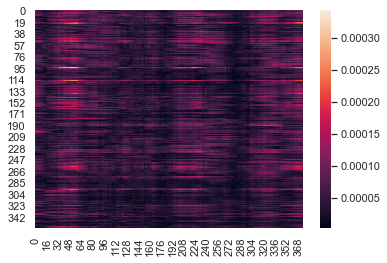

In [28]:
import seaborn as sns

sns.heatmap(v[:,158*125:161*125])

In [26]:
high = [np.array(averaging_by_parcellation(src_high1)),np.array(averaging_by_parcellation(src_high2)), 
       np.array(averaging_by_parcellation(src_high3)), np.array(averaging_by_parcellation(src_high4)), 
       np.array(averaging_by_parcellation(src_high5)), np.array(averaging_by_parcellation(src_high6)),
       np.array(averaging_by_parcellation(src_high7)), np.array(averaging_by_parcellation(src_high8)), 
       np.array(averaging_by_parcellation(src_high9)), np.array(averaging_by_parcellation(src_high10))]





In [27]:
np.savez('/users/local/Venkatesh/Generated_Data/noise_baseline_properly-done_eloreta/SI_full',high_isc_averaged = high)
#np.savez('/users/local/Venkatesh/Generated_Data/noise_baseline_properly-done_eloreta/low_isc_full',low_isc_averaged = low)

In [16]:
high = np.load('/users/local/Venkatesh/Generated_Data/noise_baseline_properly-done_eloreta/SI_full.npz')['high_isc_averaged']

In [17]:
dic = dict()
dic['condition1'] = np.array(high)
np.shape(dic['condition1'])

(10, 360, 21250)

In [18]:
[W,ISC] = CCA.train_cca(dic)

isc_results = dict()
for cond_key, cond_values in dic.items():
    isc_results[str(cond_key)] = dict(zip(['ISC', 'ISC_persecond', 'ISC_bysubject', 'A'], CCA.apply_cca(cond_values, W, 125)))


train_cca - calculations started. There are 1 conditions
Condition has 10 subjects, 360 sensors and 21250 samples
Elapsed time: 5 seconds.
apply_cca - calculations started


In [19]:
np.savez_compressed('/users/local/Venkatesh/Generated_Data/sourceCCA_ISC',sourceCCA=isc_results['condition1']['ISC_persecond'])


Text(0, 0.5, 'ISC')

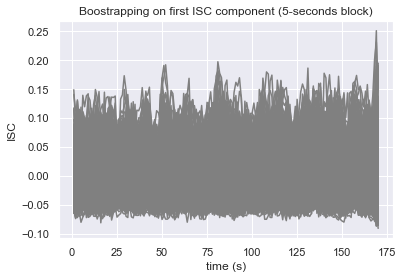

In [359]:
plt.plot(range(1,171),np.array(noise).reshape(1000,91,170)[:,0,:].T,color='grey')


plt.title('Boostrapping on first ISC component (5-seconds block)')
plt.xlabel('time (s)')
plt.ylabel('ISC')

In [313]:
plt.plot(range(1,171),np.array(valstest).reshape(1000,360,170)[:,0,:].T,color='grey')


plt.title('Boostrapping on first ISC component (5-seconds block)')
plt.xlabel('time (s)')
plt.ylabel('ISC')

ValueError: cannot reshape array of size 183600 into shape (1000,360,170)

In [328]:
significance

(array([  0,   1,   2,   3,   4,   8,   9,  10,  11,  12,  13,  14,  15,
         16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
         29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  46,  47,  48,  49,  51,  52,  53,  54,  55,  56,  57,  58,
         59,  62,  63,  64,  65,  66,  67,  68,  69,  72,  73,  74,  75,
         76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
         89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
        102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
        115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
        128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
        141, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 169]),)

In [373]:

np.shape(significance)

(1, 45)

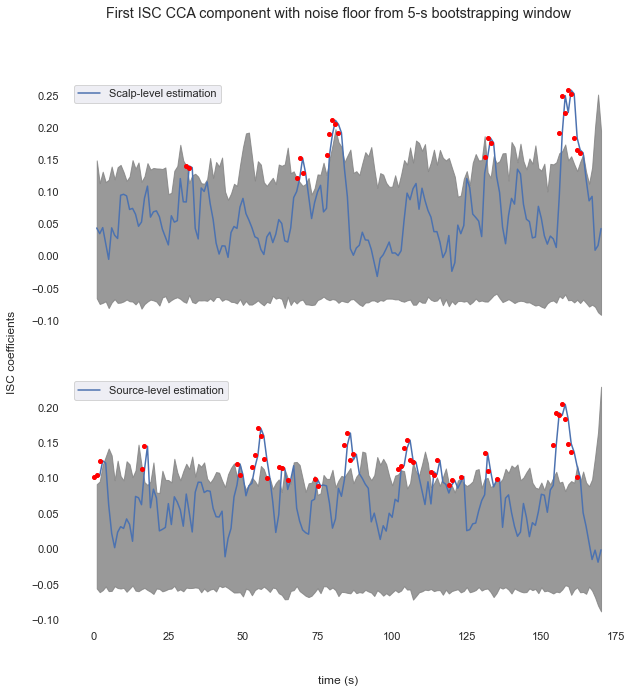

In [399]:
isc_result_old = np.load('/users/local/Venkatesh/Generated_Data/CCA_ISC.npz')['CCA_ISC']
significance = np.array(np.where(np.max(np.array(v)[:,0,:],axis=0)<isc_results['condition1']['ISC_persecond'][0]))

noise = np.load('/users/local/Venkatesh/Generated_Data/noise_floor.npz')['a']
significance_old = np.array(np.where(np.max(np.array(noise)[:,0,:],axis=0)<isc_result_old[0]))

fig = plt.figure(figsize = (10,10))
ax1 = plt.subplot(211, frameon=False)
ax2 = plt.subplot(212, frameon=False)


ax1.plot(range(1,171),isc_result_old[0], label='Scalp-level estimation')
ax1.fill_between(range(1,171),np.max(np.array(noise)[:,0,:],axis=0).T,np.min(np.array(noise)[:,0,:],axis=0).T,color ='grey',alpha=0.8)
ax1.plot(significance_old,isc_result_old[0][significance_old],
              marker='o', ls="",color='red',markersize=4)
ax1.legend(loc="upper left")



ax2.plot(range(1,171),isc_results['condition1']['ISC_persecond'][0], label='Source-level estimation')
ax2.fill_between(range(1,171),np.max(np.array(v)[:,0,:],axis=0).T,np.min(np.array(v)[:,0,:],axis=0).T,color ='grey',alpha=0.8)
ax2.plot(significance,isc_results['condition1']['ISC_persecond'][0][significance],
              marker='o', ls="",color='red',markersize=4)
ax2.legend(loc="upper left")


ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])
fig.text(0.5, 0.04, 'time (s)', ha='center')
fig.text(0.04, 0.5, 'ISC coefficients', va='center', rotation='vertical')
plt.suptitle('First ISC CCA component with noise floor from 5-s bootstrapping window')
fig.savefig('/homes/v20subra/S4B2/eLORETA_extensive_validation/scalp_source_noise_floor.jpeg')

In [316]:
plt.fill_between(range(1,171),np.max(np.array(v)[:,0,:],axis=0).T,np.min(np.array(v)[:,0,:],axis=0).T,color ='grey',alpha=0.8)
plt.plot(significance,isc_results['condition1']['ISC_persecond'][0][significance],
              marker='o', ls="",color='red')
plt.title('First component with 5-seconds block')
plt.xlabel('time (s)')
plt.ylabel('ISC')


{}

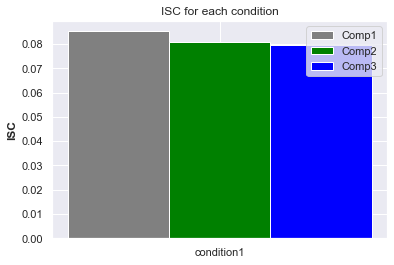

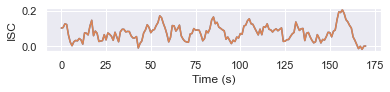

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

def plot_isc(isc_all):
    # plot ISC as a bar chart
    plt.figure()
    comp1 = [cond['ISC'][0] for cond in isc_all.values()]
    comp2 = [cond['ISC'][1] for cond in isc_all.values()]
    comp3 = [cond['ISC'][2] for cond in isc_all.values()]
    barWidth = 0.2
    r1 = np.arange(len(comp1))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    plt.bar(r1, comp1, color='gray', width=barWidth, edgecolor='white', label='Comp1')
    plt.bar(r2, comp2, color='green', width=barWidth, edgecolor='white', label='Comp2')
    plt.bar(r3, comp3, color='blue', width=barWidth, edgecolor='white', label='Comp3')
    plt.xticks([r + barWidth for r in range(len(comp1))], isc_all.keys())
    plt.ylabel('ISC', fontweight='bold')
    plt.title('ISC for each condition')
    plt.legend()
    plt.show()

    # plot ISC_persecond
    for cond in isc_all.values():
        for comp_i in range(1):
            plt.subplot(3, 1, comp_i+1)
            plt.plot(cond['ISC_persecond'][comp_i])
            #plt.plot ((np.array(vals)[:,comp_i,:]).T)
            #peaks = scipy.signal.find_peaks(isc_results['condition1']['ISC_persecond'][comp_i],distance=15)
            plt.subplots_adjust(hspace=1)

            plt.plot(isc_results['condition1']['ISC_persecond'][comp_i])
            #plt.plot(peaks[0],isc_results['condition1']['ISC_persecond'][comp_i][peaks[0]],marker='o', ls="")

            
            plt.xlabel('Time (s)')
            plt.ylabel('ISC')
            

            #plt.title('ISC per second for each condition')
    
plot_isc(isc_results)


### Noise Floor

In [310]:
#a = list(range(100))
import random
from tqdm.notebook import tqdm


valstest = []
for i in tqdm(range(3)):
    shuffled = shuffle(dic)
    isc_resultstest_ = dict()
    for cond_key, cond_values in shuffled.items():
        isc_resultstest_[str(cond_key)] = dict(zip(['ISC', 'ISC_persecond', 'ISC_bysubject', 'A'], CCA.apply_cca(cond_values, W, 125)))
        #print(np.mean(isc_results['condition1']['ISC_persecond'][0]))
        valstest.append(isc_resultstest_['condition1']['ISC_persecond'])
        #print(np.shape(isc_resultstest_['condition1']['ISC_persecond']))
#np.append(sub1_raw.get_data()[:91,516:85779].reshape(1,91,85263),sub2_raw.get

  0%|          | 0/3 [00:00<?, ?it/s]

apply_cca - calculations started
apply_cca - calculations started
apply_cca - calculations started


In [309]:
import random
from tqdm.notebook import tqdm

def shuffle(a):
    
    for k in (range(10)):
        for j in range(360):
            np.random.seed(k)
            
            chunked = chunks(a['condition1'][k][j][:21250])
            np.random.shuffle(chunked[0])
            chunked = np.reshape(chunked,[21250,])
            
    return a

def chunks(chunk):
    chunked = chunk[:21250]
    chunked= chunked.reshape(1,34,625) #5s chunk
    return chunked

        

In [312]:
from joblib import Parallel, delayed

import multiprocessing
NB_CPU = multiprocessing.cpu_count()


def process(i):
    np.random.seed(i)
    for subjects in range(10):
        rng = np.random.default_rng()
        np.random.seed(subjects)
        rng.shuffle(
                    np.swapaxes(
                                dic['condition1'][subjects,:,:].reshape(360,34,625)
                    , 0,1))
    return dict(zip(['ISC', 'ISC_persecond', 'ISC_bysubject', 'A'], CCA.apply_cca(dic['condition1'], W, 125)))['ISC_persecond']

isc_noise_floored= Parallel(n_jobs=NB_CPU-1,max_nbytes=None)(delayed(process)(i) for i in tqdm(range(1000)))


  0%|          | 0/1000 [00:00<?, ?it/s]

In [275]:
wx[1][0][0] - wx[0][0][0]

7651875

7658750

In [274]:
for q in range(10):
    np.random.seed(q)
    wqq=np.random.shuffle(np.swapaxes(wx[q,:,:].reshape(360,34,625), 0,1))
np.shape(wqq)

()

In [212]:

np.shape (
                np.random.shuffle(
                    np.swapaxes( 
                        np.reshape(
                            np.array(dic['condition1'])
                        ,(10,360,625,34)), 
                    0,3))
           )

()

In [213]:
np.shape(dic['condition1'])

(10, 360, 21250)

In [78]:
arr = np.ones((100,2,2)).T *np.arange(100)

In [202]:
np.random.shuffle(arr.T)

In [317]:
#significance = np.where(np.max(np.array(valstest)[:,0,:],axis=0)<isc_results['condition1']['ISC_persecond'][0])
np.savez_compressed('/users/local/Venkatesh/Generated_Data/noise_floor_1000_on_SI_full', a=v)

#np.shape(np.load('noise_floor.npz')['a'])

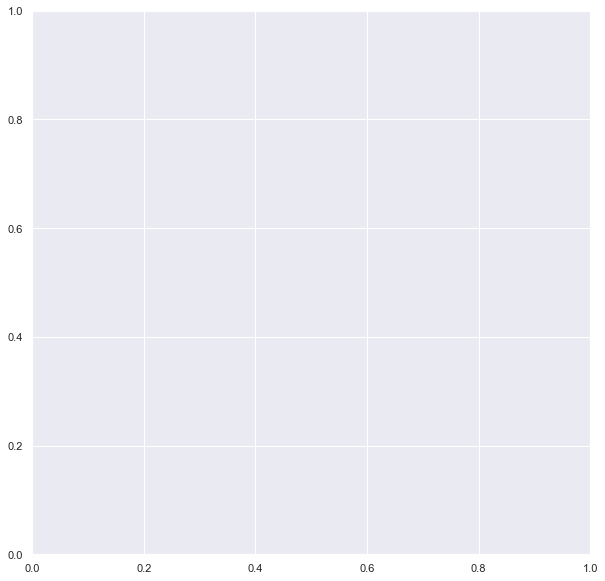

In [61]:
#np.savez('low_isc_averaged',low_isc = low_isc)

from nilearn.regions import signals_to_img_labels  
# load nilearn label masker for inverse transform
from nilearn.input_data import NiftiLabelsMasker, NiftiMasker
from nilearn.datasets import fetch_icbm152_2009
from nilearn import image, plotting
from nilearn import datasets
from os.path import join as opj


path_Glasser = 'S4B2/GSP/Glasser_masker.nii.gz'


mnitemp = fetch_icbm152_2009()
mask_mni=image.load_img(mnitemp['mask'])
glasser_atlas=image.load_img(path_Glasser)


#print(NiftiMasker.__doc__)

plt.show()
fig,ax = plt.subplots(nrows=1,ncols=1, figsize=(10,10))
signal=[]
U0_brain=[]
signal=np.expand_dims(W[:,0], axis=0) # add dimension 1 to signal array
U0_brain = signals_to_img_labels(signal,path_Glasser,mnitemp['mask'])
#plotting.plot_glass_brain(U0_brain,title='1st Spatial filter',colorbar=True,plot_abs=False,display_mode='lzr',cmap='seismic',figure=fig,axes=ax)
U0_brain.to_filename('1st_spatial_filter.nii.gz')
plotting.view_img(U0_brain,threshold=10,title='10%ile').save_as_html("10.html")

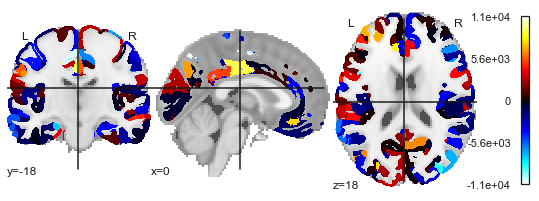

In [37]:

np.shape(W)

(360, 360)

In [55]:
np.shape(zeros)

(360, 1)

In [ ]:
numpy matplotlib sns mne pandas scipy nilearn surfplot plotly chart_studio